In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [5]:
#General plotting functions
#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

#Lollipop plot based on the python graph gallery implementation 
def LollipopPlot(Fig,Time,Data,Regression):
    
    cTime=Time
    cData=Data
    cRegression=Regression
    
    ax=Fig.gca()

    (markers, stemlines, baseline) = ax.stem(cTime, cData,bottom=-0.4,label='Data',basefmt=" ")
    plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
    plt.setp(markers, color="red",alpha=0.75 )

    ax.plot(cTime,cRegression,'b-',label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
  
    ax.set_ylabel('Normalized Population',fontsize=16,fontweight='bold')
    ax.set_xlabel('Time',fontsize=16,fontweight='bold')
    ax.legend(loc=0,fontsize=14)
    ax.set_ylim(-0.4,3.4)
    PlotStyle(ax,'')

## Parameter Estimation of Non-Linear ODE system

In [4]:
#Let's consider the Lodka-Volterra model, also known as the predator-prey model. (https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)

$\frac{\partial R}{\partial t} = R(\alpha - \beta W),  \hspace{1cm} W(0)=W_{0} \\$
$\frac{\partial W}{\partial t} = -W(\gamma - \delta R),\hspace{1cm} R(0)=R_{0}$




In [8]:
#Lodka-Volterra non linear model
def MakeModel(Alpha,Beta,Gamma,Delta,Variables):
    
    Equation1=Variables[0]*(Alpha-Beta*Variables[1])
    Equation2=-Variables[1]*(Gamma-Delta*Variables[0])
    
    return [Equation1,Equation2]

#Integration time
SolverTime=np.linspace(0,50,num=200)

#Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6

#Initial conditions 
Int=np.array([3,1])  #W(0) =3, R(0) = 1

#Model Solution 
def ODEModel(InitialConditions,t):

    return MakeModel(alpha,beta,gamma,delta,InitialConditions)

Solution=odeint(ODEModel,Int,SolverTime)

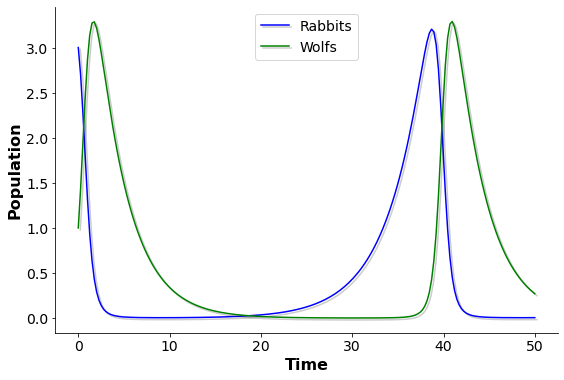

In [10]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(SolverTime,Solution[:,0],'b-',label='Rabbits',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,Solution[:,1],'g-',label='Wolfs',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Population',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')


In [12]:
###############################################################################
#                            Data generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]

WhiteNoise=[np.random.uniform(low=-1,high=1)/8 for val in Solution[:,1]]  #Assume you can only measure the number of rabbits R(t)
WhiteSignal=MakeNoisyData(Solution[:,1],WhiteNoise)

In [14]:
###############################################################################
#                    ODE system model fitting  
###############################################################################

#ModelSolver is the forward solver/integrator
def ModelSolver(t,Alpha,Beta,Gamma,Delta,InitialConditions):
    
    cAlpha=Alpha
    cBeta=Beta
    cGamma=Gamma
    cDelta=Delta
    
    cInit=InitialConditions
    
    def LocalModel(cInit,t):
        
        return MakeModel(cAlpha,cBeta,cGamma,cDelta,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def ModelFit(t,Alpha,Beta,Gamma,Delta):
    
    return ModelSolver(t,Alpha,Beta,Gamma,Delta,Int)
    
ModelParams01=curve_fit(ModelFit,SolverTime,WhiteSignal)

FitSolution=ModelSolver(SolverTime,ModelParams01[0][0],ModelParams01[0][1],ModelParams01[0][2],ModelParams01[0][3],Int) #fitted solution

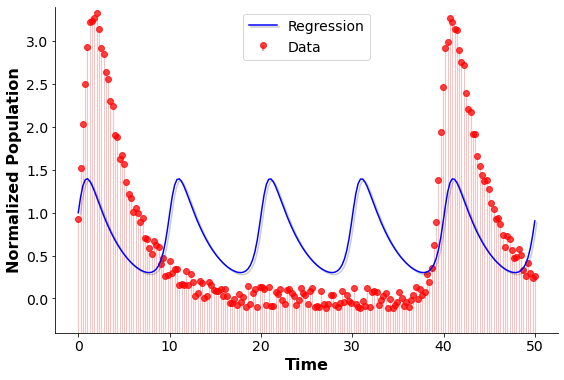

In [17]:
###############################################################################
#                    Standard parameter estimation  
###############################################################################

fig=plt.figure(2,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution)

In [18]:
#The Levenberg-Marquardt algorithm is used by curve_fit to minimize the squared error. Dimensionality of objective
# function is 4 while that of the model is 2, and the default curve_fit initial guesses (all 1's) fail to find an adequate solution

In [19]:
#Let's do a random search of the initial guess, and make use of the minimize function from scipy.optimize

##############################################################################
#                    Performance measurement
###############################################################################

#Measures the squared error between the data and the fit given an initial parameter guess
def SquaredError(InitialParameterGuess):
    
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        cModelParams=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=InitialParameterGuess)
        cSolution=ModelSolver(SolverTime,cModelParams[0][0],cModelParams[0][1],cModelParams[0][2],cModelParams[0][3],Int)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        #Based on the scale of the data the following list of values will be large enough to be rejected as a solution 
        error=[10,10]
    
    return sum(error)

In [20]:
'''
Now let's construct a random search algorithm, which will generate a list with "n" different random initial guesses and select the best approximation
'''
###############################################################################
#                    Random Search of initial values  
###############################################################################

#Random selection of the initial guess values 
def RandomSearch(Iterations):
    
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]
    
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(4)]  #we have 4 parameters to estimate hence range(4), parameters are between 0 to 1
        lerror=SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess
    
    
errs,bG=RandomSearch(10)     #let's search 10 times randomly

In [21]:
###############################################################################
#                   Initial values Random Search Fitting 
###############################################################################

ModelParams02=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=bG)
FitSolution2=ModelSolver(SolverTime,ModelParams02[0][0],ModelParams02[0][1],ModelParams02[0][2],ModelParams02[0][3],Int)

In [25]:
'''
Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6
'''
ModelParams02[0][0]

0.25925577309081677

In [26]:
ModelParams02[0][1]

0.5679012178109416

In [27]:
ModelParams02[0][2]

0.2961012934977536

In [28]:
ModelParams02[0][3]

0.6132427818217213

In [29]:
#We can see that the estimated parameters are close to the input parameters
#Let's see their covariance matrix:
ModelParams02[1]

array([[ 4.93529807e-05,  9.75097352e-05, -2.81794792e-05,
         4.70155308e-05],
       [ 9.75097352e-05,  2.03000967e-04, -5.19902215e-05,
         1.02863944e-04],
       [-2.81794792e-05, -5.19902215e-05,  1.97380712e-05,
        -1.58560261e-05],
       [ 4.70155308e-05,  1.02863944e-04, -1.58560261e-05,
         7.82353156e-05]])

In [35]:
sd_array = np.sqrt(np.diag(ModelParams02[1])) #standard deviations of estimated parameters
sd_array

array([0.00702517, 0.01424784, 0.00444275, 0.00884507])

In [59]:
np.divide(100*sd_array,ModelParams02[0]) #Standard deviations as percentage of estimated parameter values, shows good fit

array([2.70974396, 2.50885899, 1.50041726, 1.44234441])

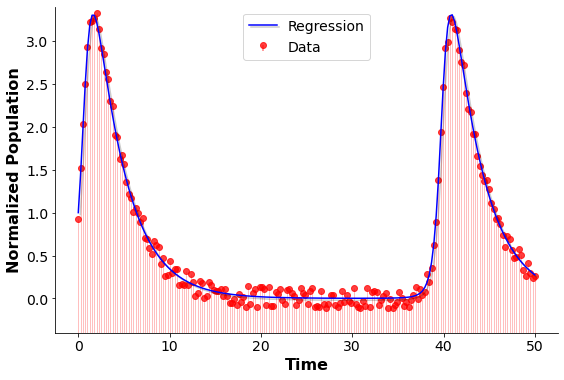

In [37]:
###############################################################################
#                              Visualization  
###############################################################################

fig=plt.figure(3,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution2)

SUCCESS, now let's try a second approach:

1. Minimize the squared error using an algorithm and get estimates for the parameters.
2. Use the result found in (1) as the initial guess for another least squares optimization (use it in curve_fit)

In [46]:
'''
A good algorithm for non-differentiable objective functions, or challenging non-linear and noisy optimization problems
is the Nelder-Mead optimization algorithm. It is often used for multidimensional nonlinear function optimization problems, although it can get stuck in local optima.
My reference for this was: https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/
'''

###############################################################################
#                    Initial values Nelder-Mean Fitting
###############################################################################

#Vector of random initial values 
g0=[np.random.uniform(low=0,high=1) for val in range(4)] 

#Minimization of the squared error by Nelder-Mead 
res = minimize(SquaredError, g0, method='nelder-mead',options={'xtol': 1e-3, 'maxiter':100,'disp': False})



In [50]:
res.success

True

In [51]:
res.message

'Optimization terminated successfully.'

In [56]:
'''
Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6
'''

res.x    #the 4 parameter estimates

array([0.69966492, 0.41463121, 0.13685135, 0.45811101])

In [57]:
#Now use the result obtained as the initial guess for curve_fit

ModelParams03=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=res.x)

FitSolution3=ModelSolver(SolverTime,ModelParams03[0][0],ModelParams03[0][1],ModelParams03[0][2],ModelParams03[0][3],Int) #the fitted curve

In [60]:
ModelParams03[0] #Much better estimates

array([0.2592559 , 0.56790148, 0.29610122, 0.61324293])

In [61]:
ModelParams03[1] #Covariance matrix

array([[ 4.93524175e-05,  9.75084598e-05, -2.81794392e-05,
         4.70147339e-05],
       [ 9.75084598e-05,  2.02998038e-04, -5.19900696e-05,
         1.02862115e-04],
       [-2.81794392e-05, -5.19900696e-05,  1.97382111e-05,
        -1.58558819e-05],
       [ 4.70147339e-05,  1.02862115e-04, -1.58558819e-05,
         7.82340318e-05]])

In [62]:
sd_array = np.sqrt(np.diag(ModelParams03[1])) #standard deviations of estimated parameters
sd_array

array([0.00702513, 0.01424774, 0.00444277, 0.008845  ])

In [63]:
np.divide(100*sd_array,ModelParams03[0]) #Standard deviations as percentage of estimated parameter values, shows good fit

array([2.70972713, 2.50883975, 1.50042293, 1.44233223])

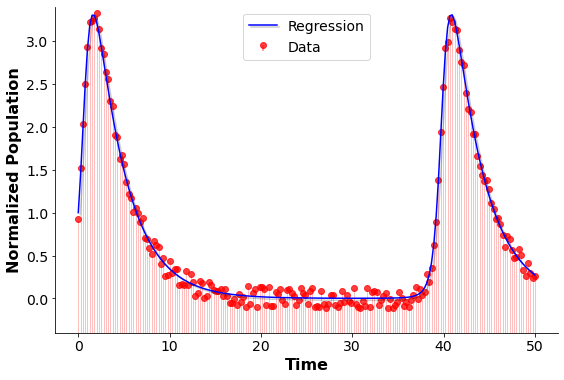

In [64]:
###############################################################################
#                              Visualization 
###############################################################################

fig=plt.figure(4,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution3)